In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn import set_config
from sklearn.inspection import permutation_importance

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
df = pd.read_csv("hotel_bookings.csv")
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [19]:
#Replace missing values
df['country'].fillna("UNK", inplace=True)
df.fillna(0, inplace=True) #this fills children, agent, and company
df['meal'].replace("Undefined", "SC", inplace=True) #Undefined is the same as SC
df.isnull().sum()

#Drop rows with no guests: 0 adults, 0 children, and 0 babies
no_guests = df[(df['adults'] == 0) & (df['children'] == 0) & (df['babies'] == 0)]
print(no_guests.shape)
df = df.drop(no_guests.index)
print(df.shape)

(0, 32)
(119210, 32)


In [20]:
majority_class = df['is_canceled'].mode()[0]

# Calculate the proportion of the majority class
proportion_majority_class = (df['is_canceled'] == majority_class).mean()

# Baseline accuracy is the proportion of the majority class
baseline_accuracy = max(proportion_majority_class, 1 - proportion_majority_class)

print(f'Majority Class: {majority_class}')
print(f'Proportion of Majority Class: {proportion_majority_class:.2f}')
print(f'Baseline Accuracy: {baseline_accuracy:.2f}')

#Std Devs above baseline
n = len(df)
baseline_std_dev = np.sqrt(baseline_accuracy * (1 - baseline_accuracy) / n)  # Assuming 'n' is the total number of samples
print(baseline_std_dev)

Majority Class: 0
Proportion of Majority Class: 0.63
Baseline Accuracy: 0.63
0.0013989418659500136


In [21]:
# Model accuracy (replace with your actual value)
model_accuracy = 0.8906

# Calculate Z-score
z_score = (model_accuracy - baseline_accuracy) / baseline_std_dev

print(f'Z-score: {z_score:.2f}')

Z-score: 186.83


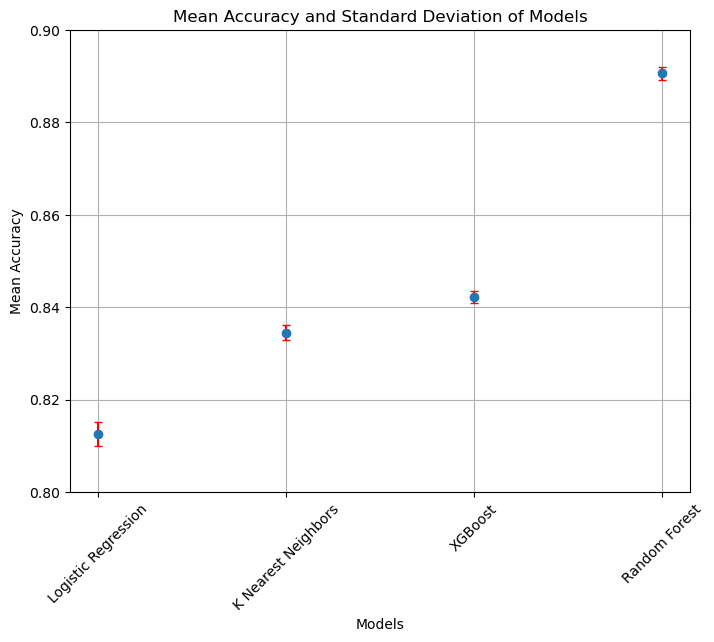

In [8]:
models = ['Logistic Regression','K Nearest Neighbors','XGBoost','Random Forest']
mean_test_scores = [0.8125,0.8345,0.8422,0.8906]
std_devs = [0.0026,0.0016,0.0014,0.0014]
plt.figure(figsize=(8, 6))
plt.ylim(0.8, 0.9)

plt.errorbar(models, mean_test_scores, yerr=std_devs, fmt='o', ecolor='red', capsize=3)
plt.title("Mean Accuracy and Standard Deviation of Models")
plt.xlabel("Models")
plt.ylabel("Mean Accuracy")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [7]:
country_cancel_data = df.groupby("country")["is_canceled"].describe()

In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(country_cancel_data)

           count      mean       std  min   25%  50%   75%  max
country                                                        
ABW          2.0  0.000000  0.000000  0.0  0.00  0.0  0.00  0.0
AGO        362.0  0.566298  0.496271  0.0  0.00  1.0  1.00  1.0
AIA          1.0  0.000000       NaN  0.0  0.00  0.0  0.00  0.0
ALB         12.0  0.166667  0.389249  0.0  0.00  0.0  0.00  1.0
AND          7.0  0.714286  0.487950  0.0  0.50  1.0  1.00  1.0
ARE         51.0  0.843137  0.367290  0.0  1.00  1.0  1.00  1.0
ARG        214.0  0.252336  0.435372  0.0  0.00  0.0  0.75  1.0
ARM          8.0  0.250000  0.462910  0.0  0.00  0.0  0.25  1.0
ASM          1.0  0.000000       NaN  0.0  0.00  0.0  0.00  0.0
ATA          2.0  0.000000  0.000000  0.0  0.00  0.0  0.00  0.0
ATF          1.0  0.000000       NaN  0.0  0.00  0.0  0.00  0.0
AUS        426.0  0.251174  0.434198  0.0  0.00  0.0  0.75  1.0
AUT       1263.0  0.182106  0.386085  0.0  0.00  0.0  0.00  1.0
AZE         17.0  0.529412  0.514496  0.

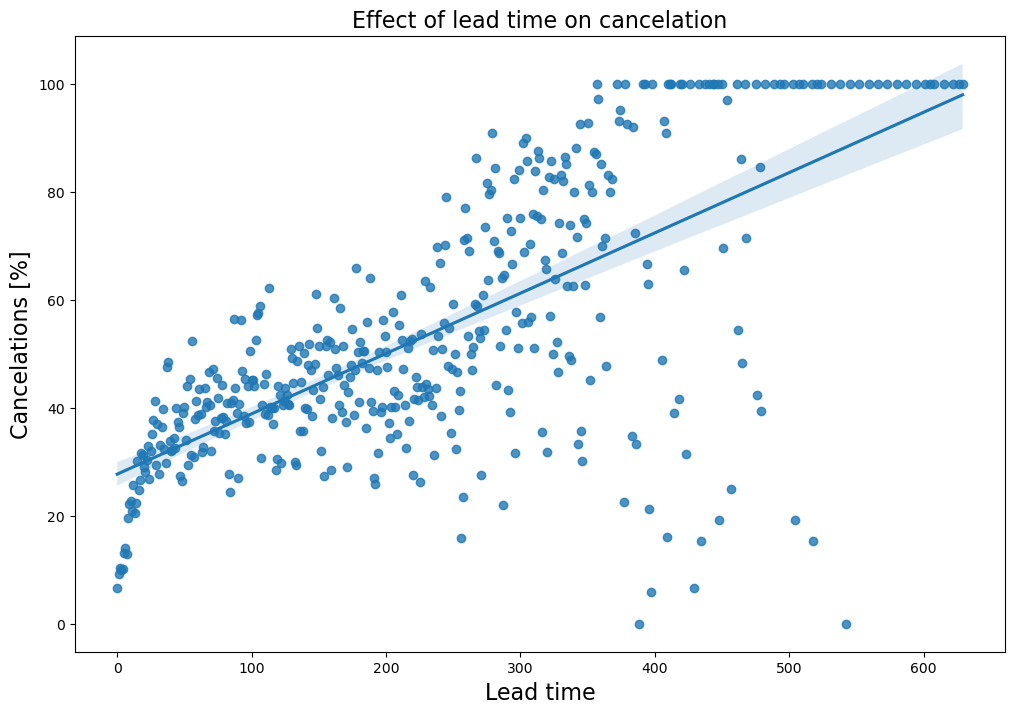

In [13]:
lead_cancel_data = df.groupby("lead_time")["is_canceled"].describe()
# use only lead_times wih more than 10 bookings for graph:
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data["count"] >= 10]

#show figure:
plt.figure(figsize=(12, 8))
sns.regplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10["mean"].values * 100)
plt.title("Effect of lead time on cancelation", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.show()